For this tutorial, we will make use of the California Housing data set

##Loading And Exploring Your Data

What you first want to be doing is importing the SparkContext from the pyspark package and initializing it. Remember that you didn’t have to do this before because the interactive Spark shell automatically created and initialized it for you!

In [4]:
import findspark

In [5]:
findspark.init()

Import the SparkSession module from pyspark.sql and build a SparkSession with the builder() method. Afterwards, you can set the master URL to connect to, the application name, add some additional configuration like the executor memory and then lastly, use getOrCreate() to either get the current Spark session or to create one if there is none running.

In [6]:
from pyspark.sql import SparkSession

# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("Linear Regression Model") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext

##Load in the data

In [22]:
# Load in the data
rdd = sc.textFile('cadata.txt')

##Data Exploration

Important to understand here is that, because Spark’s execution is “lazy” execution, nothing has been executed yet. Your data hasn’t been actually read in. The rdd and header variables are actually just concepts in your mind. You have to push Spark to work for you, so let’s use the collect() method to look at the header:

In [24]:
from pyspark.sql import Row

In [25]:
df = rdd.map(lambda line: Row(longitude=line[0], 
                              latitude=line[1], 
                              housingMedianAge=line[2],
                              totalRooms=line[3],
                              totalBedRooms=line[4],
                              population=line[5], 
                              households=line[6],
                              medianIncome=line[7],
                              medianHouseValue=line[8])).toDF()

In [34]:
df.printSchema()

root
 |-- households: string (nullable = true)
 |-- housingMedianAge: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- medianHouseValue: string (nullable = true)
 |-- medianIncome: string (nullable = true)
 |-- population: string (nullable = true)
 |-- totalBedRooms: string (nullable = true)
 |-- totalRooms: string (nullable = true)



In [40]:
from pyspark.sql.types import *

df = df.withColumn("longitude", df["longitude"].cast(FloatType())).withColumn("latitude", df["latitude"].cast(FloatType())).withColumn("housingMedianAge",df["housingMedianAge"].cast(FloatType())).withColumn("totalRooms", df["totalRooms"].cast(FloatType())).withColumn("totalBedRooms", df["totalBedRooms"].cast(FloatType())).withColumn("population", df["population"].cast(FloatType())).withColumn("households", df["households"].cast(FloatType())).withColumn("medianIncome", df["medianIncome"].cast(FloatType())).withColumn("medianHouseValue", df["medianHouseValue"].cast(FloatType()))

In [41]:
# Import all from `sql.types`
from pyspark.sql.types import *

# Write a custom function to convert the data type of DataFrame columns
def convertColumn(df, names, newType):
  for name in names: 
     df = df.withColumn(name, df[name].cast(newType))
  return df 

# Assign all column names to `columns`
columns = ['households', 'housingMedianAge', 'latitude', 'longitude', 'medianHouseValue', 'medianIncome', 'population', 'totalBedRooms', 'totalRooms']

# Conver the `df` columns to `FloatType()`
df = convertColumn(df, columns, FloatType())

In [46]:
df.select('population','totalBedRooms').take(0)

[]

In [48]:
#import Spark and MLlib packages
from pyspark import SparkContext, SparkConf
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.regression import RidgeRegressionWithSGD
from pyspark.mllib.regression import LassoWithSGD

#import data analysis packages
import numpy as np
import pandas as pd
import sklearn
from pandas import Series, DataFrame
from sklearn.linear_model import LinearRegression
from numpy import array

#import data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#misc packages
from pandas.io.data import DataReader
from datetime import datetime
from __future__ import division
from __future__ import print_function

In [49]:
# load sample dataset from seaborn
tips = sns.load_dataset("tips")

In [50]:
data_size, feature_size = tips.shape
print(data_size, feature_size)

244 7


/home/khushbuprkh/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


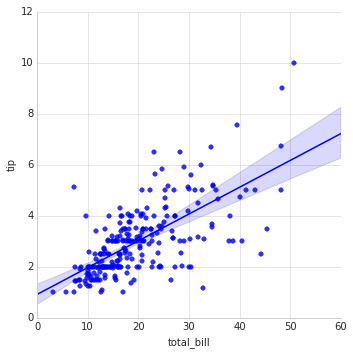

In [51]:
#"total_bill" and "tip" are column name of dataset tips
#fit regression model with simple line
g = sns.lmplot(x="total_bill", y="tip", data=tips)

In [52]:
#Seperate the X and Y axis data
X, Y = tips.total_bill, tips.tip
X = np.vstack(X)

In [53]:
result = np.linalg.lstsq(X,Y)
error_total = result[1]
mse = error_total/len(X)
print(mse)

[ 1.17811612]


In [54]:
#Split the dataset as train and test
X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(X, Y)

In [55]:
#Let's see the size of them
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(183, 1) (61, 1) (183,) (61,)


In [56]:
#Train the linear regression by scikit-learn model
lreg = LinearRegression()
lreg.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [57]:
#Predict on training and testing set
pred_train = lreg.predict(X_train)
pred_test = lreg.predict(X_test)

In [58]:
#Calculate the root mean square error
print("Fit a model X_train and calculate the MSE with Y_train: %.2f" %np.mean((Y_train-pred_train)**2))
print("Fit a model X_train and calculate the MSE with X_test and Y_test: %.2f" %np.mean((Y_test-pred_test)**2))

Fit a model X_train and calculate the MSE with Y_train: 1.10
Fit a model X_train and calculate the MSE with X_test and Y_test: 0.86


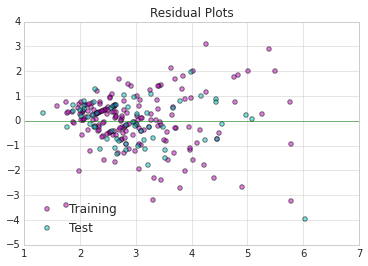

In [59]:

#Scatterly plot the traing data
train = plt.scatter(pred_train, (pred_train-Y_train), c='m', alpha = 0.5)
test = plt.scatter(pred_test, (pred_test-Y_test), c='c', alpha = 0.5)

#Plot a horizontal axis line at y-axis=0
plt.axhline(y=0, xmin=-1, xmax=10, c='g', alpha=0.5)

# Set labels
plt.legend((train,test), ('Training', 'Test'), loc='lower left')
plt.title('Residual Plots')

In [71]:
#dump the tips to a local file for now
Y = np.vstack(Y)
fo = open("tips.data", "w")
for i in range(data_size):    
    fo.write("{},{}\n".format(float(X[i][0]), float(Y[i][0]))) 

fo.close()

In [72]:
sc = SparkContext("local", "tip_linear_regression")

In [74]:
df_RDD = sc.textFile("tips.data")

In [75]:
# parase the dataset, replace "," as space
#columns from index 1 will be consider as vectors
def parsePoint(line):
    values = [float(x) for x in line.replace(',', ' ').split(' ')]
    return LabeledPoint(values[0], values[1:])

parsedData = df_RDD.map(parsePoint)

In [76]:
#verify if parsing and map works
#view the first 10 rows. 
parsedData.take(10)

[LabeledPoint(16.99, [1.01]),
 LabeledPoint(10.34, [1.66]),
 LabeledPoint(21.01, [3.5]),
 LabeledPoint(23.68, [3.31]),
 LabeledPoint(24.59, [3.61]),
 LabeledPoint(25.29, [4.71]),
 LabeledPoint(8.77, [2.0]),
 LabeledPoint(26.88, [3.12]),
 LabeledPoint(15.04, [1.96]),
 LabeledPoint(14.78, [3.23])]

In [77]:

def linearRegression_f(mode):
    if   mode == "no_reg":
         model = LinearRegressionWithSGD.train(parsedData)
    elif mode == "L1_reg":
         model = LassoWithSGD.train(parsedData)
    elif mode == "L2_reg":
         model = RidgeRegressionWithSGD.train(parsedData)
    else:
        print("ERROR Mode")
        
    #Evaluate the model on training data
    # parsedData map method to get {train_data, predict_data} pairs 
    valuesAndPreds = parsedData.map(lambda p: (p.label, model.predict(p.features)))
    
    #calculate the key-value pairs to get MSE
    MSE = valuesAndPreds.map(lambda (v, p): (v-p)**2).reduce(lambda x, y: x+y)/valuesAndPreds.count()
    
  
    return MSE

In [79]:

MSE = linearRegression_f("no_reg")
print("LinearRegression Mean Squared Error = " +str(MSE))

MSE = linearRegression_f("L1_reg")
print("RidgeRegression Mean Squared Error = " +str(MSE))

MSE = linearRegression_f("L2_reg")
print("Lasso Mean Squared Error = " +str(MSE))

/home/khushbuprkh/spark-2.2.0-bin-hadoop2.7/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")
/home/khushbuprkh/spark-2.2.0-bin-hadoop2.7/python/pyspark/mllib/regression.py:423: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression with elasticNetParam = 1.0. Note the default regParam is 0.01 for LassoWithSGD, but is 0.0 for LinearRegression.
  "Deprecated in 2.0.0. Use ml.regression.LinearRegression with elasticNetParam = 1.0. "


LinearRegression Mean Squared Error = 50.8613458552
RidgeRegression Mean Squared Error = 50.861372917
Lasso Mean Squared Error = 50.861833327


/home/khushbuprkh/spark-2.2.0-bin-hadoop2.7/python/pyspark/mllib/regression.py:567: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression with elasticNetParam = 0.0. Note the default regParam is 0.01 for RidgeRegressionWithSGD, but is 0.0 for LinearRegression.
  "Deprecated in 2.0.0. Use ml.regression.LinearRegression with elasticNetParam = 0.0. "
